# Skin segmentation 

In this assignement you will train classifier to assign colors to skin or no skin classes. The data is taken from [Skin Segmentation Data Set](http://archive.ics.uci.edu/ml/datasets/Skin+Segmentation#) in the UCI Machine Learning repository.

The  data is in a plain text format and contains four columns. First three contain RGB color data  represented as integers in the range 0-255, and the last column is an integer label  with 1 representing skin and 2 representing no skin. This file we can load directly into a numpy array:

In [4]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [5]:
data = np.loadtxt('Skin_NonSkin.txt')

In [42]:
data

array([[ 74.,  85., 123.,   1.],
       [ 73.,  84., 122.,   1.],
       [ 72.,  83., 121.,   1.],
       ...,
       [163., 162., 112.,   2.],
       [163., 162., 112.,   2.],
       [255., 255., 255.,   2.]])

In [43]:
rgb  = data[:,:3]
lbl = data[:,3].astype('int32') # some function expect labels to be integers

We see that the classes are not balanced:

In [44]:
np.bincount(lbl)

array([     0,  50859, 194198])

In [9]:
#df = pd.DataFrame(data, columns = ['R', 'G', 'B', 'Skin'])

In [45]:
#Oversampling unbalanced classes
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(rgb, lbl)
df = pd.DataFrame(X_resampled, columns = ['R', 'G', 'B'])
y = pd.DataFrame(y_resampled, columns = ['Skin'])
df = df.join(y)
df.head()

,R,G,B,Skin
0,74.0,85.0,123.0,1
1,73.0,84.0,122.0,1
2,72.0,83.0,121.0,1
3,70.0,81.0,119.0,1
4,70.0,81.0,119.0,1


## Problem 1 

Compare the performance of the QuadraticDiscriminantAnalysis, LinearDiscriminativeAnalysis and NaiveBayes classifiers on this set. Use the `sklearn` library when needed. Compare the confusion matrices (tpr, fpr, tnr, fnr), precision and f1_ score and auc_score, as well ROC curves. Prepare a summary table with all the numerical scores one row per classifier on one column per metric (use pandas.DataFame). Plot all  ROC curves on the same plot and label them accordingly. Assume that skin is positive and non-skin negative. 

__Hint__ as you will be repeating this it's probably a good idea  to write a python function that does all the analysis. 

In [46]:
def analize(cls, name, train_X, train_Y, test_X, test_Y):
    fprs = tprs = thds = None
    
    cls.fit(train_X, train_Y)
    #test_X = cls.transform(test_X)
    y_pred = cls.predict(test_X)
    
    
    tn, fp, fn, tp = confusion_matrix(test_Y, y_pred).ravel()
    fprs, tprs, thds = roc_curve(test_Y, y_pred, pos_label = 1)

    precision = precision_score(test_Y, y_pred)
    f1 = f1_score(test_Y, y_pred)
    auc = roc_auc_score(test_Y, y_pred)
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    tnr = 1 - fpr
    fnr = 1 - tpr

    return  pd.DataFrame({'tnr': tnr,
                          'fnr': fnr,
                          'fpr': fpr,
                          'tpr': tpr,
                          'precision' : precision,
                          'f1' : f1,
                          'auc' : auc
                           }, index=[name]), fprs, tprs, thds

In [47]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [48]:
#Analysis
summary = pd.DataFrame()

model_lda = LinearDiscriminantAnalysis()
analize_lda = analize(model_lda, "lda", X_train, y_train, X_test, y_test)
summary = summary.append(analize_lda[0])

model_qda = QuadraticDiscriminantAnalysis()
analize_qda = analize(model_qda, "qda", X_train, y_train, X_test, y_test)
summary = summary.append(analize_qda[0])

model_NB = GaussianNB()
analize_NB = analize(model_NB, "nb", X_train, y_train, X_test, y_test)
summary = summary.append(analize_NB[0])


summary

,tnr,fnr,fpr,tpr,precision,f1,auc
lda,1.000000,0.086417,0.000000,0.913583,0.920648,0.958685,0.956792
qda,0.994425,0.002166,0.005575,0.997834,0.997833,0.996126,0.996130
nb,0.834201,0.053582,0.165799,0.946418,0.939793,0.883854,0.890309


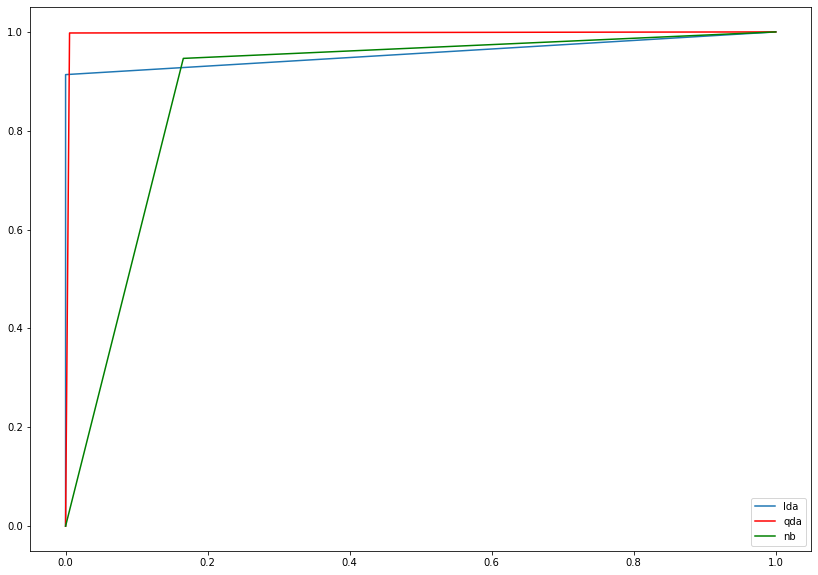

In [49]:
#ROC curves
plt.figure(figsize = (14, 10))
plt.plot(analize_lda[2], analize_lda[1])
plt.plot(analize_qda[2], analize_qda[1], color = 'red')
plt.plot(analize_NB[2], analize_NB[1], color = 'green')
plt.legend(["lda", "qda", "nb"])
plt.show()

## Problem 2

Repeat same analysis but with RGB  data converted to Hue  Saturation Value (HSV) format. You can use the `colorsys` module for conversion 

In [50]:
from colorsys import rgb_to_hsv
hsv = np.asarray([rgb_to_hsv(*row) for row in rgb]) #inneficient but it does not matter

In [51]:
#Oversampling unbalanced classes
ros = RandomOverSampler()
X_resampled_hsv, y_resampled_hsv = ros.fit_resample(hsv, lbl)
df_hsv = pd.DataFrame(X_resampled_hsv, columns = ['H', 'S', 'V'])
y_hsv = pd.DataFrame(y_resampled_hsv, columns = ['Skin'])
df_hsv = df_hsv.join(y_hsv)
df_hsv.head()

,H,S,V,Skin
0,0.629252,0.398374,123.0,1
1,0.629252,0.401639,122.0,1
2,0.629252,0.404959,121.0,1
3,0.629252,0.411765,119.0,1
4,0.629252,0.411765,119.0,1


In [52]:
#Train test split
X_train_hsv, X_test_hsv, y_train_hsv, y_test_hsv = train_test_split(X_resampled_hsv, y_resampled_hsv)

In [53]:
#Analysis
summary_hsv = pd.DataFrame()

model_lda = LinearDiscriminantAnalysis()
analize_lda_hsv = analize(model_lda, "lda", X_train_hsv, y_train_hsv, X_test_hsv, y_test_hsv)
summary_hsv = summary_hsv.append(analize_lda_hsv[0])

model_qda = QuadraticDiscriminantAnalysis()
analize_qda_hsv = analize(model_qda, "qda", X_train_hsv, y_train_hsv, X_test_hsv, y_test_hsv)
summary_hsv = summary_hsv.append(analize_qda_hsv[0])

model_NB = GaussianNB()
analize_NB_hsv = analize(model_NB, "nb", X_train_hsv, y_train_hsv, X_test_hsv, y_test_hsv)
summary_hsv = summary_hsv.append(analize_NB[0])

summary_hsv

,tnr,fnr,fpr,tpr,precision,f1,auc
lda,1.000000,0.112775,0.000000,0.887225,0.898193,0.946367,0.943612
qda,0.991843,0.006143,0.008157,0.993857,0.993813,0.992827,0.992850
nb,0.834201,0.053582,0.165799,0.946418,0.939793,0.883854,0.890309


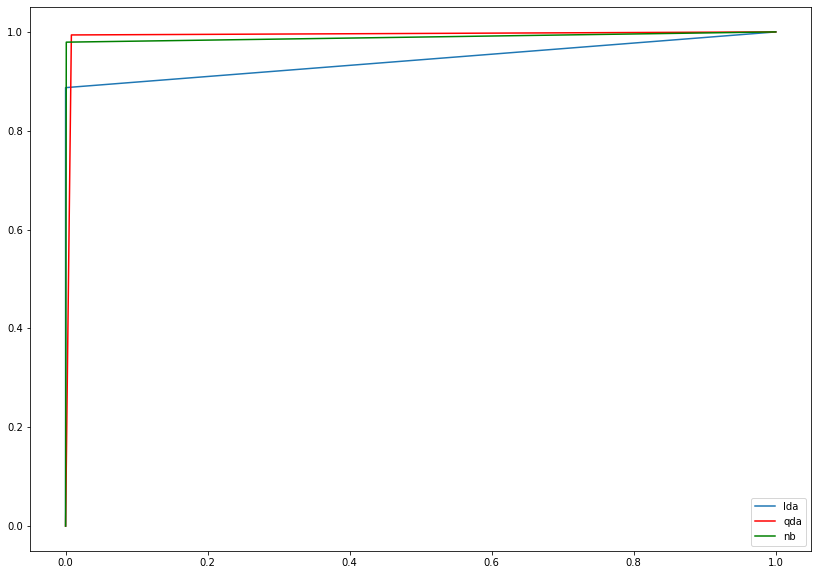

In [54]:
#ROC curves
plt.figure(figsize = (14, 10))
plt.plot(analize_lda_hsv[2], analize_lda_hsv[1])
plt.plot(analize_qda_hsv[2], analize_qda_hsv[1], color = 'red')
plt.plot(analize_NB_hsv[2], analize_NB_hsv[1], color = 'green')
plt.legend(["lda", "qda", "nb"])
plt.show()